<a id='header'></a>
# Principal Component Analysis (PCA)

In this notebook we present PCA-related functionalities from the ``reduction`` module.

### PCA functionalities

- [**Section 1**](#global_local_pca): We present how *global and local PCA* can be performed using `PCA` class from the `reduction` module.
- [**Section 2**](#plotting_pca): We present the plotting functionalities from the `reduction` module for viewing PCA results.

***

**Should plots be saved?**

In [1]:
save_plots = False

***
<a id='global_local_pca'></a>
## Global vs. local PCA

[**Go up**](#header)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PCAfold import PCA
from PCAfold import preprocess
from PCAfold import reduction
from sklearn.cluster import KMeans

# Set some initial parameters:
global_color = '#6a6e7a'
k1_color = '#0e7da7'
k2_color = '#ceca70'
PC_color = '#000000'
data_point = 4
font_text = 20
line_width = 1
n_points = 1000

# Fonts:
csfont = {'fontname':'Charter', 'fontweight':'regular'}
hfont = {'fontname':'Charter', 'fontweight':'bold'}

# Function for plotting:
def plot_data_set(x, y, title_text=''):
    
    figure = plt.figure(figsize=(8, 5))
    figureSubplot = plt.subplot(1,1,1)
    plt.scatter(x, y, color=global_color, marker='.', linewidth=data_point-2)
    plt.xticks([]), plt.yticks([])
    plt.grid(alpha=0.2)
    plt.title(title_text, **csfont, fontsize=font_text, color=PC_color)

Create a function that will perform PCA transformation on local portions of the data set:

In [3]:
def local_pca(X, idx):

    n_k = len(np.unique(idx))

    # Initialize the outputs:
    eigenvectors = []
    eigenvalues = []
    PC_scores = []

    for k in range(0, n_k):

        # Extract local cluster:
        X_k = X[idx==k]

        # Perform PCA in a local cluster:
        pca = PCA(X_k, scaling='none', n_components=2, useXTXeig=True)
        PC_scores = pca.transform(X_k, nocenter=False)
        eigenvectors.append(pca.Q)
        eigenvalues.append(pca.L)

    return (eigenvectors, eigenvalues, PC_scores)

***

### Generate synthetic data set on which global PCA will be performed:

This data set is composed of a single cloud:

In [4]:
mean_global = [0,1]
covariance_global = [[3.4, 1.1], [1.1, 2.1]]

x_noise, y_noise = np.random.multivariate_normal(mean_global, covariance_global, n_points).T
y_global = np.linspace(0,4,n_points)
x_global = -(y_global**2) + 7*y_global + 4
y_global = y_global + y_noise
x_global = x_global + x_noise

Dataset_global = np.hstack((x_global[:,np.newaxis], y_global[:,np.newaxis]))

Visualize the data set:

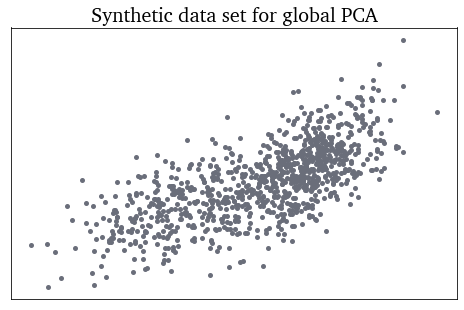

In [5]:
plot_data_set(x_global, y_global, 'Synthetic data set for global PCA')
if save_plots==True: plt.savefig('../images/tutorial-pca-data-set-for-global-pca.png', dpi = 500, bbox_inches='tight')

Perform PCA transformation of the data set:

In [6]:
# Perform PCA:
pca = PCA(Dataset_global, 'none', 2, useXTXeig=True)
PC_scores_global = pca.transform(Dataset_global, nocenter=False)
eigenvectors_global = pca.Q
eigenvalues_global = pca.L

# Centered data set:
Dataset_global_pp = pca.X_cs

***

### Generate synthetic data set on which local PCA will be performed

This data set is composed of two distinct clouds:

In [7]:
mean_local_1 = [0,1]
mean_local_2 = [6,4]
covariance_local_1 = [[2, 0.5], [0.5, 0.5]]
covariance_local_2 = [[3, 0.3], [0.3, 0.5]]

x_noise_1, y_noise_1 = np.random.multivariate_normal(mean_local_1, covariance_local_1, n_points).T
x_noise_2, y_noise_2 = np.random.multivariate_normal(mean_local_2, covariance_local_2, n_points).T
x_local = np.concatenate([x_noise_1, x_noise_2])
y_local = np.concatenate([y_noise_1, y_noise_2])

Dataset_local = np.hstack((x_local[:,np.newaxis], y_local[:,np.newaxis]))

Visualize the data set:

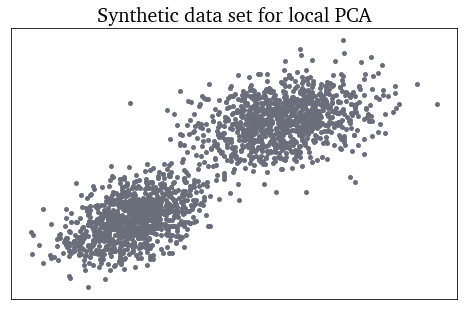

In [8]:
plot_data_set(x_local, y_local, 'Synthetic data set for local PCA')
if save_plots==True: plt.savefig('../images/tutorial-pca-data-set-for-local-pca.png', dpi = 500, bbox_inches='tight')

Cluster the data set using K-Means algorithm:

In [9]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Dataset_local)
idx = kmeans.labels_
centroids = kmeans.cluster_centers_

Perform local PCA:

In [10]:
(eigenvectors_local, eigenvalues_local, _) = local_pca(Dataset_local, idx)

***

### Plotting global vs. local PCA

Plot the identified eigenvectors on the data set where global PCA was performed and on the data set where local PCA was performed:

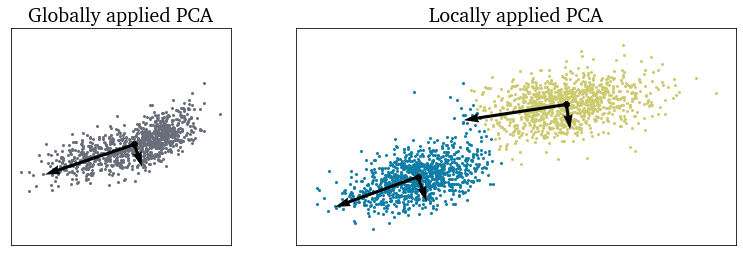

In [11]:
figure = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# First subplot - global PCA:
figureSubplot = plt.subplot(gs[0])
plt.scatter(Dataset_global_pp[:,0], Dataset_global_pp[:,1], s=data_point, color=global_color, marker='o', linewidth=line_width)

# Plot global eigenvectors:
plt.quiver(eigenvectors_global[0,0], eigenvectors_global[1,0], scale=30*(1-eigenvalues_global[0]), color=PC_color, width=0.014)
plt.quiver(eigenvectors_global[0,1], eigenvectors_global[1,1], scale=10*(1-eigenvalues_global[1]), color=PC_color, width=0.014)

plt.axis('equal')
plt.yticks([]), plt.xticks([])
plt.title('Globally applied PCA', **csfont, fontsize=font_text, color=PC_color)

# Plot global centroid:
plt.scatter(0, 0, color=PC_color, marker='x', lineWidth=data_point, s=20);

# Second subplot - local PCA:
figureSubplot = plt.subplot(gs[1])
plt.scatter(Dataset_local[idx==0,0], Dataset_local[idx==0,1], s=data_point, c=k1_color, marker='o')
plt.scatter(Dataset_local[idx==1,0], Dataset_local[idx==1,1], s=data_point, c=k2_color, marker='o')

# Plot local eigenvectors:
origin = [centroids[0][0]], [centroids[0][1]]
plt.quiver(*origin, eigenvectors_local[0][0,0], eigenvectors_local[0][1,0], scale=30*(1-eigenvalues_local[0][0]), color=PC_color, width=0.007)
plt.quiver(*origin, eigenvectors_local[0][0,1], eigenvectors_local[0][1,1], scale=20*(1-eigenvalues_local[0][1]), color=PC_color, width=0.007)

origin = [centroids[1][0]], [centroids[1][1]]
plt.quiver(*origin, eigenvectors_local[1][0,0], eigenvectors_local[1][1,0], scale=30*(1-eigenvalues_local[1][0]), color=PC_color, width=0.007)
plt.quiver(*origin, eigenvectors_local[1][0,1], eigenvectors_local[1][1,1], scale=20*(1-eigenvalues_local[1][1]), color=PC_color, width=0.007)

plt.axis('equal')
plt.yticks([]), plt.xticks([])
plt.title('Locally applied PCA', **csfont, fontsize=font_text, color=PC_color)

# Plot local centroids:
plt.scatter(centroids[:, 0], centroids[:, 1], color=PC_color, marker='x', lineWidth=data_point, s=20);

if save_plots==True: plt.savefig('../images/tutorial-pca-global-local-pca.png', dpi = 500, bbox_inches='tight')

***
<a id='plotting_pca'></a>
## Plotting PCA results

[**Go up**](#header)

Below we demonstrate plotting PCA results using the functions available in the ``reduction`` module.

In [12]:
# Set some initial parameters:
title = None
save_filename = None
X_names = ['$T$', '$H_2$', '$O_2$', '$O$', '$OH$', '$H_2O$', '$H$', '$HO_2$', '$CO$', '$CO_2$', '$HCO$']

# Upload the sample data set:
X = pd.read_csv('data-state-space.csv', sep = ',', header=None).to_numpy()

Create three PCA objects corresponding to different data scaling criteria:

In [13]:
pca_X_Auto = PCA(X, scaling='auto', n_components=2)
pca_X_Range = PCA(X, scaling='range', n_components=2)
pca_X_Vast = PCA(X, scaling='vast', n_components=2)
pca_X_Pareto = PCA(X, scaling='pareto', n_components=2)

### Eigenvectors

Plot eigenvectors from one of the scaling options:

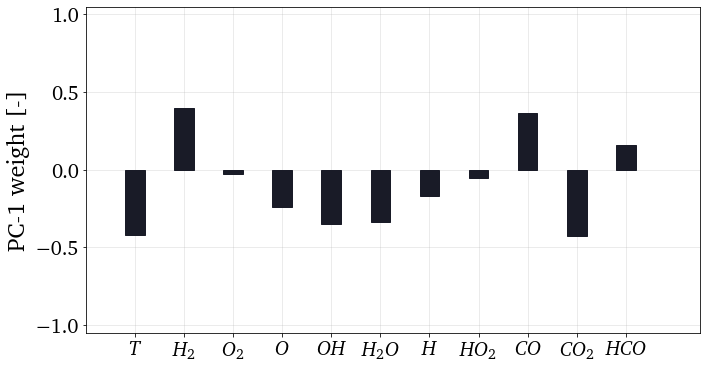

In [14]:
plt = reduction.plot_eigenvectors(pca_X_Auto.Q[:,0], eigenvectors_indices=[], variable_names=X_names, plot_absolute=False, title=None, save_filename=None)

Plot absolute values:

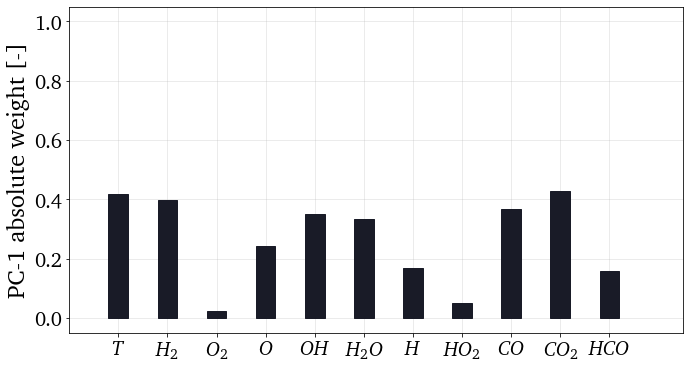

In [15]:
plt = reduction.plot_eigenvectors(pca_X_Auto.Q[:,0], eigenvectors_indices=[], variable_names=X_names, plot_absolute=True, title=None, save_filename=None)

Plot comparison of eigenvectors from all scaling options:

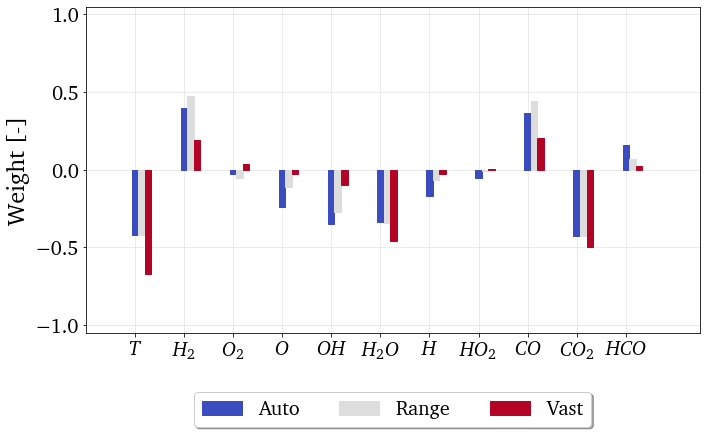

In [16]:
plt = reduction.plot_eigenvectors_comparison((pca_X_Auto.Q[:,0], pca_X_Range.Q[:,0], pca_X_Vast.Q[:,0]), legend_labels=['Auto', 'Range', 'Vast'], variable_names=X_names, plot_absolute=False, color_map='coolwarm', title=None, save_filename=None)

Plot absolute values:

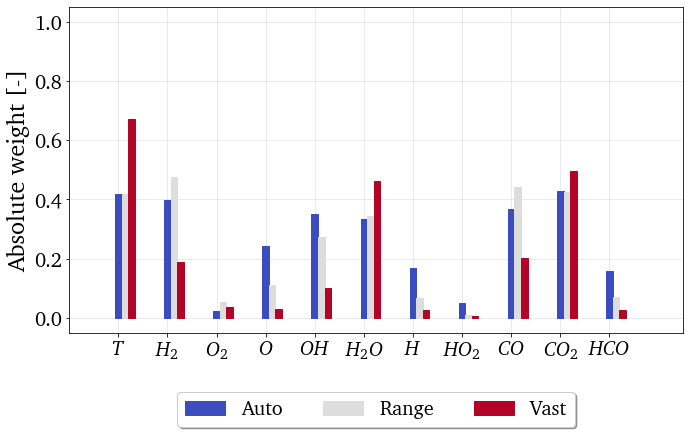

In [17]:
plt = reduction.plot_eigenvectors_comparison((pca_X_Auto.Q[:,0], pca_X_Range.Q[:,0], pca_X_Vast.Q[:,0]), legend_labels=['Auto', 'Range', 'Vast'], variable_names=X_names, plot_absolute=True, color_map='coolwarm', title=None, save_filename=None)

### Eigenvalues

Plot eigenvalue distribution:

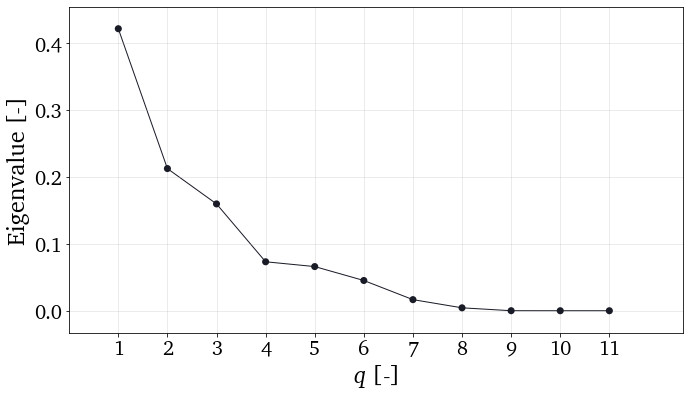

In [18]:
plt = reduction.plot_eigenvalue_distribution(pca_X_Auto.L, normalized=False, title=None, save_filename=None)

Plot normalized eigenvalue distribution:

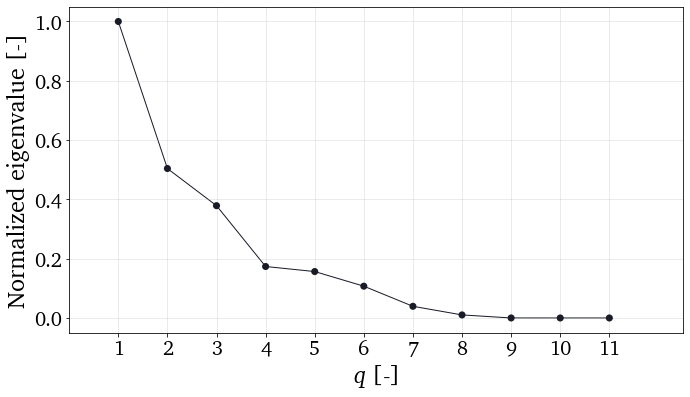

In [19]:
plt = reduction.plot_eigenvalue_distribution(pca_X_Auto.L, normalized=True, title=None, save_filename=None)

Plot comparison of eigenvalues from all scaling options:

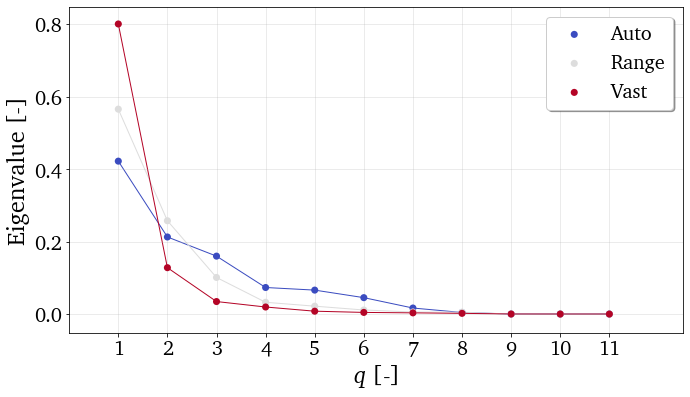

In [20]:
plt = reduction.plot_eigenvalue_distribution_comparison((pca_X_Auto.L, pca_X_Range.L, pca_X_Vast.L), legend_labels=['Auto', 'Range', 'Vast'], normalized=False, color_map='coolwarm', title=None, save_filename=None)

Plot absolute values:

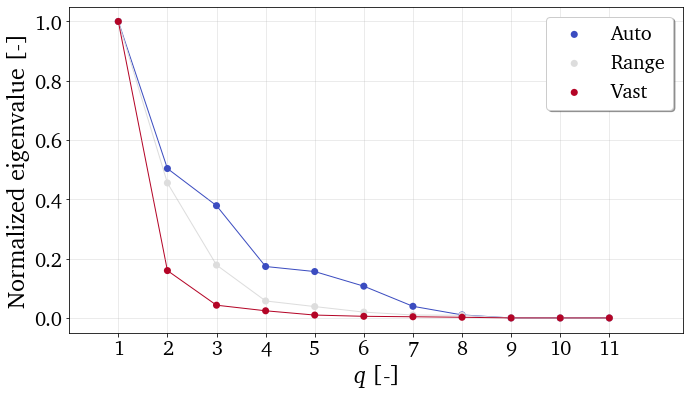

In [21]:
plt = reduction.plot_eigenvalue_distribution_comparison((pca_X_Auto.L, pca_X_Range.L, pca_X_Vast.L), legend_labels=['Auto', 'Range', 'Vast'], normalized=True, color_map='coolwarm', title=None, save_filename=None)

### Two-dimensional manifold

Finally, we transform the original data set to the new basis:

In [22]:
principal_components = pca_X_Vast.transform(X)

and we plot the two-dimensional manifold:

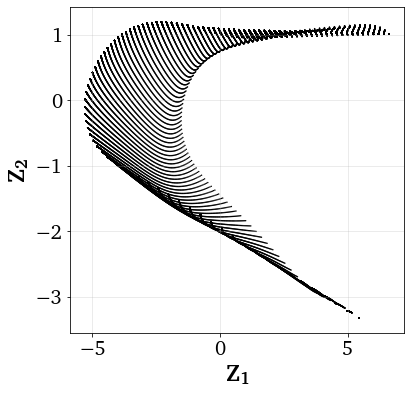

In [23]:
plt = reduction.plot_2d_manifold(principal_components, color_variable='k', x_label='$\mathbf{Z_1}$', y_label='$\mathbf{Z_2}$', colorbar_label=None, title=None, save_filename=None)

two-dimensional manifold colored by temperature variable:

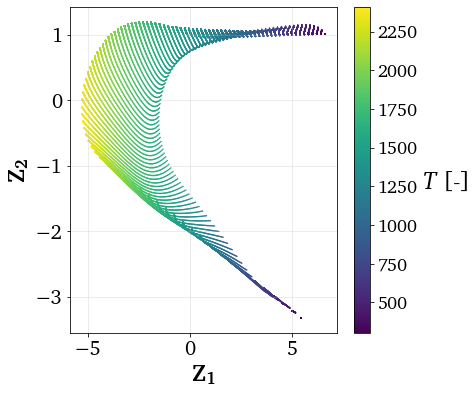

In [24]:
plt = reduction.plot_2d_manifold(principal_components, color_variable=X[:,0], x_label='$\mathbf{Z_1}$', y_label='$\mathbf{Z_2}$', colorbar_label='$T$ [-]', title=None, save_filename=None)